In [ ]:
# Download the data 
!mkdir graph_data
!wget https://www.physi.uni-heidelberg.de/~dittmeier/pytorch/graph_data/graphs_pT2GeV.zip
#wget https://www.physi.uni-heidelberg.de/~dittmeier/pytorch/graph_data/graphs_no_pTCut.zip # uncomment this line to download the data without pT cut

In [ ]:
!unzip graphs_pT2GeV.zip -d graph_data
#!unzip graphs_no_pTCut.zip -d graph_data   # uncomment this line to unzip the data without pT cut

In [1]:
data_dir = 'graph_data/pTge2GeV'
#data_dir = 'graph_data/nopTCut/' # uncomment this line to use the data without pT cut
## for local use:
data_dir = '/mnt/data0/Trackml_dataset_100_events/seb/metric_learning/nopTCut' # pTge2GeV

In [2]:
#install required packages
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
#ensure that the PyTorch and the PyG are the same version
#!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
#!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
#!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

2.1.0+cu121


In [3]:
from torch_geometric.data import Data

# Define the path to the PyG file
file_path = f'{data_dir}/trainset/event000021000.pyg'

# Load the PyG file
data = torch.load(file_path)

# Print the properties of the PyG file
print(data)
print(data.num_nodes)
print(data.num_edges)
print(data.edge_index)
print(data.y)
print(data.truth_map)
print(data.track_edges)
print(data.x)
print(data.r)
print(data.phi)
print(data.z)

DataBatch(leta=[125576], module_index=[125576], lx=[125576], region=[125576], lphi=[125576], cell_val=[125576], weight=[125576], lz=[125576], phi=[125576], ly=[125576], x=[125576], hit_id=[125576], eta=[125576], geta=[125576], y=[951115], r=[125576], cell_count=[125576], z=[125576], gphi=[125576], track_edges=[2, 96834], particle_id=[96834], radius=[96834], pt=[96834], nhits=[96834], config=[2], event_id=[1], batch=[125576], ptr=[2], edge_index=[2, 951115], truth_map=[96834])
125576
951115
tensor([[     0,      0,     39,  ..., 125573, 125575, 125573],
        [     7,     18,      0,  ..., 125570, 125570, 125575]])
tensor([False, False,  True,  ..., False, False, False])
tensor([   263,     -1,    288,  ..., 951087, 951099, 951093])
tensor([[    21,     23,     24,  ..., 125569, 125573, 125574],
        [ 66118,  67271,  67282,  ..., 125560, 125564, 125562]])
tensor([ -86.7962,  -68.7035,  -56.1383,  ..., -884.3330, -987.7320,
        -926.3450], dtype=torch.float64)
tensor([ 88.0373,

In [4]:
from utils.version_utils import get_pyg_data_keys
from utils import (
    load_datafiles_in_dir,
    handle_weighting,
)

device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
print(device)

cuda:7


In [5]:
from torch_geometric.data import Dataset

class GraphDataset(Dataset):
    """
    The custom default GNN dataset to load graphs off the disk
    """

    def __init__(
        self,
        input_dir,
        data_name=None,
        num_events=None,
        stage="fit",
        hparams=None,
        transform=None,
        pre_transform=None,
        pre_filter=None,
        preprocess=True,
    ):
        if hparams is None:
            hparams = {}
        super().__init__(input_dir, transform, pre_transform, pre_filter)

        self.input_dir = input_dir
        self.data_name = data_name
        self.hparams = hparams
        self.num_events = num_events
        self.stage = stage
        self.preprocess = preprocess
        self.transform = transform

        self.input_paths = load_datafiles_in_dir(
            self.input_dir, self.data_name, self.num_events
        )
        self.input_paths.sort()  # We sort here for reproducibility

    def len(self):
        return len(self.input_paths)

    def get(self, idx):
        event_path = self.input_paths[idx]
        event = torch.load(event_path, map_location=torch.device("cpu"))
        # convert DataBatch to Data instance because some transformations don't work on DataBatch
        event = Data(**event.to_dict())
        if not self.preprocess:
            return event
        event = self.preprocess_event(event)
        # do pyg transformation if a torch_geometric.transforms instance is given
        if self.transform is not None:
            event = self.transform(event)

        # return (event, event_path) if self.stage == "predict" else event
        return event
    
    def preprocess_event(self, event):
        """
        Process event before it is used in training and validation loops
        """
        event = self.construct_weighting(event)
        event = self.scale_features(event)
        return event

    def construct_weighting(self, event):
        """
        Construct the weighting for the event
        """

        assert event.y.shape[0] == event.edge_index.shape[1], (
            f"Input graph has {event.edge_index.shape[1]} edges, but"
            f" {event.y.shape[0]} truth labels"
        )

        if self.hparams is not None and "weighting" in self.hparams.keys():
            assert isinstance(self.hparams["weighting"], list) & isinstance(
                self.hparams["weighting"][0], dict
            ), "Weighting must be a list of dictionaries"
            event.weights = handle_weighting(event, self.hparams["weighting"])
        else:
            event.weights = torch.ones_like(event.y, dtype=torch.float32)

        return event


    def scale_features(self, event):
        """
        Handle feature scaling for the event
        """

        if (
            self.hparams is not None
            and "node_scales" in self.hparams.keys()
            and "node_features" in self.hparams.keys()
        ):
            assert isinstance(
                self.hparams["node_scales"], list
            ), "Feature scaling must be a list of ints or floats"
            for i, feature in enumerate(self.hparams["node_features"]):
                assert feature in get_pyg_data_keys(
                    event
                ), f"Feature {feature} not found in event"
                event[feature] = event[feature] / self.hparams["node_scales"][i]

        return event

In [6]:
weighting_false = {
    "weight": 0.1,
    "conditions": {
        "y": False
    }
}

weighting_bckg = {
    "weight": 0,
    "conditions": {
        "y": True
    }
}

weighting_target = {
    "weight": 1,
    "conditions": {
        "y": True,
        "pt": [1., float('inf')],
        "nhits": [3, float('inf')]
    }
}

parameters = {
    "node_features": ["r",  "phi", "z"],
    "node_scales": [1000, 3.14,  1000],
    "weighting": [weighting_false,
                  weighting_bckg,
                  weighting_target], # list of dictionaries
}


trainset = GraphDataset(f"{data_dir}/trainset", hparams=parameters)
valset = GraphDataset(f"{data_dir}/valset", hparams=parameters)
testset = GraphDataset(f"{data_dir}/testset", hparams=parameters)
print("Number of samples in trainset:", len(trainset))
print("Number of samples in valset:", len(valset))
print("Number of samples in testset:", len(testset))


Number of samples in trainset: 80
Number of samples in valset: 10
Number of samples in testset: 10


In [7]:
from torch_geometric.loader import DataLoader

# Set batch size and number of workers
batch_size = 1
num_workers = 1

# Create dataloaders
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

for test_event in train_loader:
    print(test_event.r)
    print(test_event.y.shape)
    print(test_event.weights.shape)
    print(test_event.weights)
    num_zero_weights = (test_event.weights == 0).sum().item()   
    print("Number of 0 weights:", num_zero_weights)
    num_point1_weights = (test_event.weights == 0.1).sum().item()
    print("Number of 0.1 weights:", num_point1_weights)
    num_one_weights = (test_event.weights == 1).sum().item()
    print("Number of 1 weights:", num_one_weights)
    
    break

tensor([0.0911, 0.0779, 0.1002,  ..., 0.9223, 0.9121, 0.8796],
       dtype=torch.float64)
torch.Size([657801])
torch.Size([657801])
tensor([0.1000, 1.0000, 0.1000,  ..., 0.1000, 0.1000, 0.1000])
Number of 0 weights: 46844
Number of 0.1 weights: 600865
Number of 1 weights: 10092


In [8]:
from torch_geometric.nn import MessagePassing
import torch
import torch.nn as nn

# https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_gnn.html

class InteractionConv(MessagePassing):
    def __init__(
        self,
        hidden_dim,
        aggr="add",
        *,
        aggr_kwargs={},
        flow: str = "source_to_target",
        node_dim: int = -2,
        decomposed_layers: int = 1,
        **kwargs
    ):
        super().__init__(
            aggr,
            aggr_kwargs=aggr_kwargs,
            flow=flow,
            node_dim=node_dim,
            decomposed_layers=decomposed_layers,
            **kwargs
        )
        
        self.node_network = nn.Sequential(
            nn.Linear(2*hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.edge_network = nn.Sequential(
            nn.Linear(3*hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

    def message(self,e):
        # constructs messages for each edge; e as given to propagate
        return e

    def aggregate(
        self,
        inputs: torch.Tensor,
        index: torch.Tensor,
        edge_index,
        x,
        ptr=None,
        dim_size=None,
    ) -> torch.Tensor:
        # takes output from message as first argument (inputs = e), and can take any other data passed to propagate
        # so the edge data is creating a message for source and destination nodes
        src_message = self.aggr_module(inputs, edge_index[1], dim_size=x.size(0))
        dst_message = self.aggr_module(inputs, edge_index[0], dim_size=x.size(0))
        out = src_message + dst_message
        return out

    def update(self, inputs: torch.Tensor, x) -> torch.Tensor:
        # takes the aggregated messages and the node data and updates the node data
        x_in = torch.cat([x, inputs], dim=1)
        out = self.node_network(x_in)
        return out

    def edge_update(self, edge_index, x, e) -> torch.Tensor:
        x_in = torch.cat([x[edge_index[0]], x[edge_index[1]], e], dim=1)
        out = self.edge_network(x_in)
        return out

    def forward(self, edge_index, x, e):
        # propagate: initial call to start propagating messages, takes edge indices and any other data
        # propagate calls message, aggreate and update functions
        x = self.propagate(edge_index=edge_index, x=x, e=e)
        # then we update our edge features, this calls edge_update
        e = self.edge_updater(edge_index=edge_index, x=x, e=e)
        return x, e



In [9]:
class InteractionNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_iterations=2):
        super(InteractionNetwork, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_iterations = n_iterations
        
        self.node_encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.edge_encoder = nn.Sequential(
            nn.Linear(2*hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.conv = InteractionConv(hidden_dim)
        
        self.edge_classifier = nn.Sequential(
            nn.Linear(3* hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
    # we take a full data batch, and make use of features we want 
    def forward(self, batch):
        # Extract node features
        x = torch.stack([batch.r, batch.phi, batch.z], dim=-1).to(torch.float32)
        edge_index = batch.edge_index
        #print(f"x= {x}")
        #print(f"edge_index= {edge_index.shape}")
        
        #if "undirected" in self.hparams and self.hparams["undirected"]:
        #edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)
        #print(f"edge_index= {edge_index.shape}")

        start, end = edge_index
        x.requires_grad = True
        #print(start, end)

        x = self.node_encoder(x)
        e = self.edge_encoder(torch.cat([x[start], x[end]], dim=-1))
        #print(x)
        #print(e)
        # Message passing
        for i in range(self.n_iterations):
            x, e = self.conv(edge_index, x, e)
            
        #return
        # Decode edge features
        decoded = self.edge_classifier(torch.cat([x[start], x[end], e], dim=-1))
        
        #print(decoded)
        return decoded


In [12]:
model = InteractionNetwork(input_dim=3, hidden_dim=128, n_iterations=8).to(device)
print(test_event)
test_run = model(test_event.to(device))
print(test_run)
del test_run
torch.cuda.empty_cache()


DataBatch(x=[105865], edge_index=[2, 657801], y=[657801], leta=[105865], module_index=[105865], lx=[105865], region=[105865], lphi=[105865], cell_val=[105865], weight=[105865], lz=[105865], phi=[105865], ly=[105865], hit_id=[105865], eta=[105865], geta=[105865], r=[105865], cell_count=[105865], z=[105865], gphi=[105865], track_edges=[2, 79332], particle_id=[79332], radius=[79332], pt=[79332], nhits=[79332], config=[1], event_id=[1], batch=[105865], truth_map=[79332], weights=[657801], ptr=[2])
tensor([[-0.0618],
        [-0.0659],
        [-0.0672],
        ...,
        [-0.0655],
        [-0.0739],
        [-0.0631]], device='cuda:7', grad_fn=<AddmmBackward0>)


In [13]:
learning_rate = 1e-2
epochs = 50
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [14]:
import torch.nn.functional as F

def loss_function(output, batch):
        """
        Applies the loss function to the output of the model and the truth labels.
        To balance the positive and negative contribution, simply take the means of each separately.
        Any further fine tuning to the balance of true target, true background and fake can be handled
        with the `weighting` config option.
        """

        assert hasattr(batch, "y"), (
            "The batch does not have a truth label. Please ensure the batch has a `y`"
            " attribute."
        )
        assert hasattr(batch, "weights"), (
            "The batch does not have a weighting label. Please ensure the batch"
            " weighting is handled in preprocessing."
        )

        negative_mask = ((batch.y == 0) & (batch.weights != 0)) | (batch.weights < 0)
        #print(output[negative_mask].squeeze().shape)
        #print(torch.zeros_like(output[negative_mask]).squeeze().shape)
        #print(batch.weights[negative_mask].abs().shape)

        negative_loss = F.binary_cross_entropy_with_logits(
            output[negative_mask].squeeze(),
            torch.zeros_like(output[negative_mask]).squeeze(),
            weight=batch.weights[negative_mask].abs(),
            reduction="sum",
        )

        positive_mask = (batch.y == 1) & (batch.weights > 0)
        positive_loss = F.binary_cross_entropy_with_logits(
            output[positive_mask].squeeze(),
            torch.ones_like(output[positive_mask]).squeeze(),
            weight=batch.weights[positive_mask].abs(),
            reduction="sum",
        )

        n = positive_mask.sum() + negative_mask.sum()
        return (
            (positive_loss + negative_loss) / n,
            positive_loss.detach() / n,
            negative_loss.detach() / n,
        )

In [16]:
# loops over our optimization code
def train_loop(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    print(f"current learning rate: {optimizer.param_groups[0]['lr']}")
    for batchid, batch in enumerate(dataloader):

        output = model(batch.to(device))
        loss, pos_loss, neg_loss = loss_fn(output, batch)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batchid % 10 == 0:
            loss, current = loss.item(), batchid * batch_size + len(batch.event_id)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

        # Clear GPU memory
        del batch, output, loss
        torch.cuda.empty_cache()
    scheduler.step()



In [17]:
# evaluate the model's performance against the test dataset
def test_loop(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    test_loss = 0
    with torch.no_grad():   
        for batchid, batch in enumerate(dataloader):

            output = model(batch.to(device))
            loss, pos_loss, neg_loss = loss_fn(output, batch)
            test_loss += loss

            scores = torch.sigmoid(output.squeeze())
            #print(scores)
            efficiencies = []
            purities = []
            for i in range(0, 100, 5):
                score_cut = i / 100
                score_cut_mask = (scores > score_cut)
                positive_mask = (batch.y == 1) & (batch.weights > 0)    # only checking for target edges
                scored_positive = (score_cut_mask & positive_mask).sum()
                #print(f"scored_negative: {scored_negative}")
                #print(f"scored_positive: {scored_positive}")
                efficiency = scored_positive / positive_mask.sum()
                purity = scored_positive / score_cut_mask.sum()
                efficiencies.append(efficiency.item())
                purities.append(purity.item())
                #print(f"efficiency: {efficiency}")
                #print(f"purity: {purity}")
            

            # Clear GPU memory
            del batch, output, loss, scores, score_cut_mask, positive_mask
            torch.cuda.empty_cache()
    test_loss /= size
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
    return test_loss.item(), efficiencies, purities


In [18]:
loss = []
eff  = []
pur  = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_function, optimizer, device)
    l, e, p = test_loop(val_loader, model, loss_function, optimizer, device)
    loss.append(l)
    eff.append(e)
    pur.append(p)
print("Done!")

Epoch 1
-------------------------------
current learning rate: 0.01
loss: 0.077421  [    1/   80]
loss: 0.047315  [   11/   80]
loss: 0.051806  [   21/   80]
loss: 0.051269  [   31/   80]
loss: 0.049114  [   41/   80]
loss: 0.046452  [   51/   80]
loss: 0.049373  [   61/   80]
loss: 0.047215  [   71/   80]
Test Error: 
 Avg loss: 0.047500 

Epoch 2
-------------------------------
current learning rate: 0.01
loss: 0.052080  [    1/   80]
loss: 0.046680  [   11/   80]
loss: 0.052957  [   21/   80]
loss: 0.052350  [   31/   80]
loss: 0.046409  [   41/   80]
loss: 0.044567  [   51/   80]
loss: 0.044920  [   61/   80]
loss: 0.047829  [   71/   80]
Test Error: 
 Avg loss: 0.047118 

Epoch 3
-------------------------------
current learning rate: 0.01
loss: 0.047501  [    1/   80]
loss: 0.050309  [   11/   80]


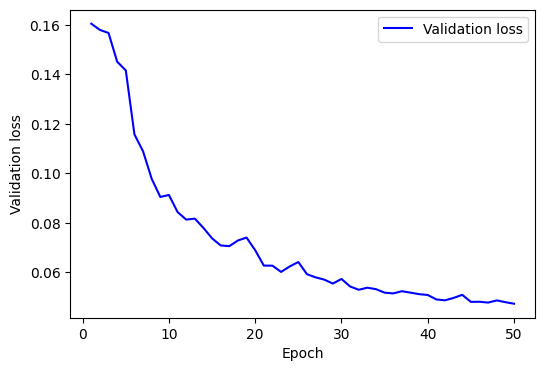

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95]


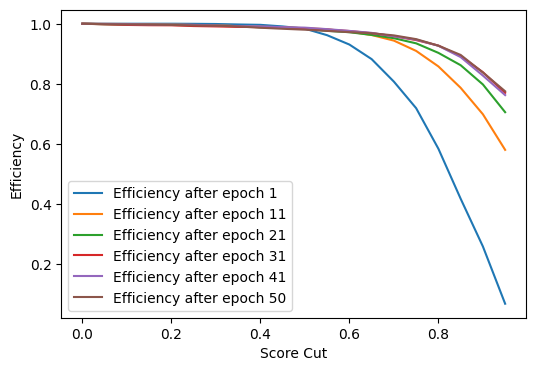

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95]


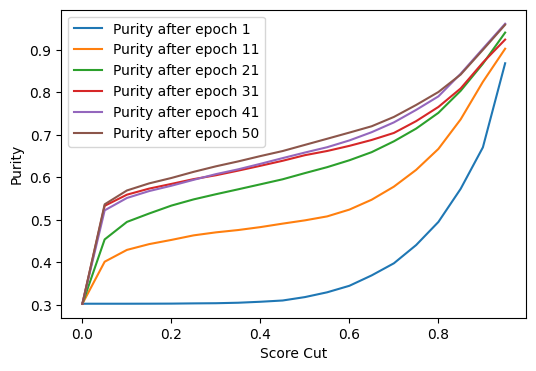

Efficiency: 0.9984447956085205
Purity: 0.5366098284721375
Efficiency: 0.9800933003425598
Purity: 0.6764705777168274


In [61]:
#for name, param in model.named_parameters():
#    print(f"Parameter name: {name}, Size: {param.size()}, Values: {param}")

# Assuming you have the `test_loss` variable containing the loss values for each epoch
import numpy as np

epochs_r = range(1, len(loss) + 1)
plt.figure(figsize=(6, 4))
plt.plot(epochs_r, loss, 'b', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Validation loss')
plt.legend()
plt.show()

score_cut = np.arange(0, 1 ,0.05)
print(score_cut)
plt.figure(figsize=(6, 4))
plt.xlabel('Score Cut')
plt.ylabel('Efficiency')
for i, y in enumerate(eff):
    if i % 10 == 0 or i == len(pur)-1:
        plt.plot(score_cut, y, label=f'Efficiency after epoch {i+1}')
#plt.ylim(0.9, 1)
plt.legend()
plt.show()
    
score_cut = np.arange(0, 1 ,0.05)
print(score_cut)
plt.figure(figsize=(6, 4))
plt.xlabel('Score Cut')
plt.ylabel('Purity')
for i, y in enumerate(pur):
    if i % 10 == 0 or i == len(pur)-1:
        plt.plot(score_cut, y, label=f'Purity after epoch {pur.index(y)+1}')
#plt.ylim(0.5, 1)
plt.legend()
plt.show()

# print the final efficiency and purity at 0.05 score cut
print(f"Efficiency: {eff[-1][1]}")
print(f"Purity: {pur[-1][1]}")
# and at 0.5 score cut
print(f"Efficiency: {eff[-1][10]}")
print(f"Purity: {pur[-1][10]}")